<h3>Model Evaluation</h3>

In [ ]:
from model import InsiderClassifier, LSTM_Encoder, CNN_Classifier

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

Dataset

In [ ]:
class InsiderThreatDataset(Dataset):
    def __init__(self, X_path, y_path):
        self.X = pd.read_pickle(X_path)
        self.y = pd.read_pickle(y_path)

        # Convert to Tensors: X must be Long (for nn.Embedding input), y must be Float
        self.X = torch.tensor(self.X.tolist(), dtype=torch.long)
        # Unsqueeze(1) makes labels (N, 1) for standard binary classification
        self.y = torch.tensor(self.y.values.astype(float), dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Evaluation Method

In [ ]:
BATCH_SIZE = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def evaluate_model(X_SUBSET_PATH, Y_SUBSET_PATH, MODEL_WEIGHTS_PATH, LSTM_CHECKPOINT_PATH='kk'):
    # ------------------------------------
    # 1. Initialization and Data Loading
    # ------------------------------------
    current_device = torch.device(DEVICE)
    print(f"Starting evaluation on device: {current_device}")

    # Load subset dataset
    subset_dataset = InsiderThreatDataset(X_SUBSET_PATH, Y_SUBSET_PATH)
    dataloader = DataLoader(
        subset_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False, # Don't shuffle for evaluation
        num_workers=0  # Safe mode for evaluation
    )

    # ------------------------------------
    # 2. Model Loading
    # ------------------------------------

    # Instantiate the model architecture
    model = InsiderClassifier(
        lstm_checkpoint=LSTM_CHECKPOINT_PATH,
        device=current_device
    )

    # Load the trained CNN weights from model.pkl
    try:
        # Load the state dictionary
        state_dict = torch.load(MODEL_WEIGHTS_PATH, map_location=current_device)

        # Load the state dictionary into the instantiated model
        model.load_state_dict(state_dict)
        print(f"Successfully loaded weights from {MODEL_WEIGHTS_PATH}")
    except FileNotFoundError:
        print(f"Error: Model weights file not found at {MODEL_WEIGHTS_PATH}")
        print("Please ensure 'model.pkl' is in the current directory.")
        return
    except Exception as e:
        print(f"Error loading model weights: {e}")
        return

    # Set the model to evaluation mode (disables dropout, preserves frozen encoder)
    model.eval()

    # ------------------------------------
    # 3. Inference and Prediction
    # ------------------------------------
    all_predictions = []
    all_labels = []
    start_time = time.perf_counter() # start timer

    print("Running inference...")
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            # Move data to device
            X_batch = X_batch.to(current_device)

            # Forward pass (scores are log-probabilities)
            scores = model(X_batch)

            # Get the predicted class index (0 or 1)
            # torch.max returns (values, indices). We want the indices.
            _, predicted_classes = torch.max(scores, 1)

            # Append results: predicted classes (CPU) and true labels (CPU)
            all_predictions.extend(predicted_classes.cpu().numpy())
            all_labels.extend(y_batch.long().squeeze(1).cpu().numpy())

    end_time = time.perf_counter() # end timer

    # ------------------------------------
    # 4. Calculate Accuracy
    # ------------------------------------

    true_labels = np.array(all_labels)
    predicted_labels = np.array(all_predictions)

    accuracy = accuracy_score(true_labels, predicted_labels)
    prec = precision_score(true_labels, predicted_labels)
    rec = recall_score(true_labels, predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])

    print("\n======================================")
    print(f"EVALUATION COMPLETE on {len(true_labels)} samples")

    print(f"Accuracy Score (sklearn): {accuracy:.4f}")
    print(f"Precision Score (sklearn): {prec:.4f}")
    print(f"Recall Score (sklearn): {rec:.4f}")

    print("F1: ", f1_score(true_labels, predicted_labels))
    print(f"\nTime taken for inference: {end_time - start_time} seconds")

    # displaying the confusion matrix
    print("\nConfusion Matrix:\n")

    disp.plot()
    plt.show()

    print("\n======================================")


Evaluation on Test Set

Starting evaluation on device: cuda
Successfully loaded weights from /content/drive/My Drive/ITD_Files/Models/model0.9.pkl
Running inference...

EVALUATION COMPLETE on 117362 samples
Accuracy Score (sklearn): 0.9910
Precision Score (sklearn): 0.0726
Recall Score (sklearn): 0.1109
F1:  0.08777969018932874

Time taken for inference: 12.878676697999936 seconds

Confusion Matrix:



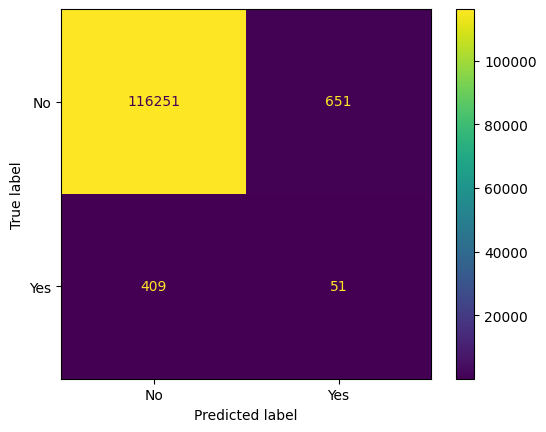

In [ ]:
evaluate_model(X_SUBSET_PATH = 'X_test.pkl', Y_SUBSET_PATH = 'y_test.pkl', MODEL_WEIGHTS_PATH = 'model0.9.pkl')

Evaluation on Scenario 1

Starting evaluation on device: cuda


/tmp/ipython-input-1282348425.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  self.X = torch.tensor(self.X.tolist(), dtype=torch.long)


Successfully loaded weights from model_epoch_8.pkl
Running inference...

EVALUATION COMPLETE on 5818 samples
Accuracy Score (sklearn): 0.9892
Precision Score (sklearn): 0.6964
Recall Score (sklearn): 0.4588
F1:  0.5531914893617021

Time taken for inference: 1.6712896669999964 seconds

Confusion Matrix:



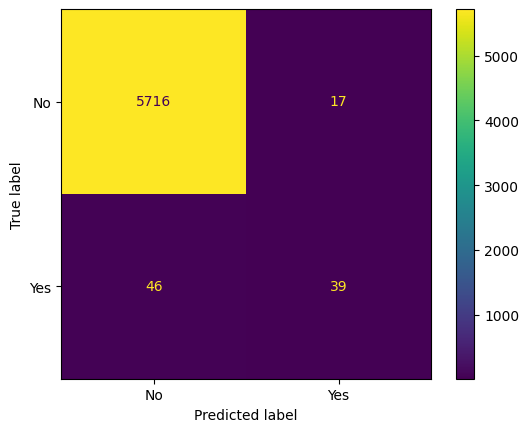

In [ ]:
evaluate_model(X_SUBSET_PATH = 'X_S1.pkl', Y_SUBSET_PATH = 'y_S1.pkl', MODEL_WEIGHTS_PATH = 'model_epoch_8.pkl')

Evaluation on Scenario 2

Starting evaluation on device: cuda
Successfully loaded weights from model_0.3.pkl
Running inference...

EVALUATION COMPLETE on 6312 samples
Accuracy Score (sklearn): 0.9072
Precision Score (sklearn): 0.6528
Recall Score (sklearn): 0.7801
F1:  0.7107601184600197

Time taken for inference: 0.7118993130000035 seconds

Confusion Matrix:



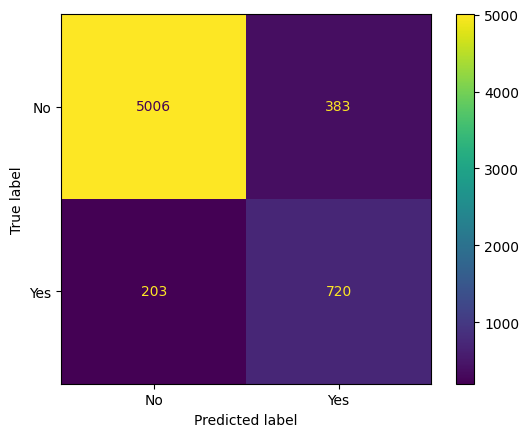

In [ ]:
evaluate_model(X_SUBSET_PATH = 'X_S2.pkl', Y_SUBSET_PATH = 'y_S2.pkl', MODEL_WEIGHTS_PATH = 'model_0.3.pkl')

Evaluation on Scenario 3

Starting evaluation on device: cuda
Successfully loaded weights from model_0.28.pkl
Running inference...

EVALUATION COMPLETE on 2400 samples
Accuracy Score (sklearn): 0.9958
Precision Score (sklearn): 0.5000
Recall Score (sklearn): 0.3000
F1:  0.375

Time taken for inference: 0.33015294699998776 seconds

Confusion Matrix:



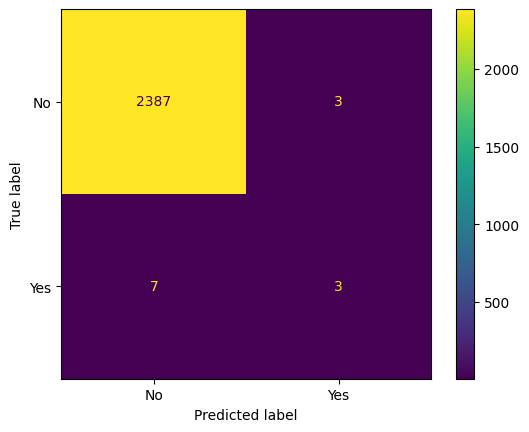

In [ ]:
evaluate_model(X_SUBSET_PATH = 'X_S3.pkl', Y_SUBSET_PATH = 'y_S3.pkl', MODEL_WEIGHTS_PATH = 'model_0.28.pkl')

Evaluation on Scenario 4

Starting evaluation on device: cuda
Successfully loaded weights from model_0.3.pkl
Running inference...

EVALUATION COMPLETE on 9189 samples
Accuracy Score (sklearn): 0.9282
Precision Score (sklearn): 0.7441
Recall Score (sklearn): 0.7383
F1:  0.7411764705882353

Time taken for inference: 0.9648134910000294 seconds

Confusion Matrix:



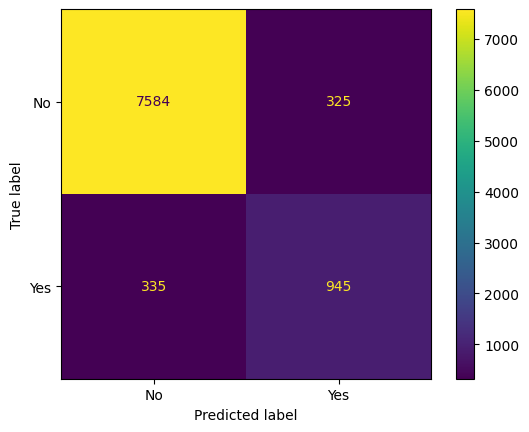

In [ ]:
evaluate_model(X_SUBSET_PATH = 'X_S4.pkl', Y_SUBSET_PATH = 'y_S4.pkl', MODEL_WEIGHTS_PATH = 'model_0.3.pkl')